In [1]:
import joblib
import click
import json
import time
import os
import itertools
import collections.abc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from qiskit_ibm_provider import IBMProvider

from quantum.Evaluate import evaluate
from settings import ANSATZ_LIST, ENCODER_LIST

In [2]:
"M_Modified-Pauli-CRZ.json"

'M_Modified-Pauli-CRZ.json'

In [3]:
# Global variables
OPTIMIZER = None
SHOTS = None
X_DIM = None
BACKEND = None
DEVICE = None
SCALE_FACTORS = None
ANSATZ = None
ENCODER = None
POSTPROCESS = None
ERROR_MITIGATION = None
LAYERS = None
PROVIDER = None
TOKEN = None
HYPERPARAMETERS = None
RE_UPLOAD_DEPTH = None
MAX_ITER = None
TOLERANCE = None
NUM_QUBITS = None

In [4]:
def parse_settings(settings_file):
    with open(settings_file, 'r') as fp:
        settings = json.load(fp)

    global OPTIMIZER
    OPTIMIZER = settings['OPTIMIZER']

    global SHOTS
    SHOTS = settings['SHOTS']

    global BACKEND
    BACKEND = settings['BACKEND']

    global DEVICE
    DEVICE = settings['DEVICE']

    global SCALE_FACTORS
    SCALE_FACTORS = settings['SCALE_FACTORS']

    global POSTPROCESS
    POSTPROCESS = settings['POSTPROCESS']

    global ERROR_MITIGATION
    ERROR_MITIGATION = settings['ERROR_MITIGATION']

    global LAYERS
    LAYERS = settings['LAYERS']

    global HYPERPARAMETERS
    HYPERPARAMETERS = settings['HYPERPARAMETERS']
    # f was removed from HYPERPARAMETERS, this ensures old settings files can still run.
    if 'f' in HYPERPARAMETERS.keys():
        _ = HYPERPARAMETERS.pop('f', None)

    global RE_UPLOAD_DEPTH
    RE_UPLOAD_DEPTH = settings['RE-UPLOAD_DEPTH']

    global MAX_ITER
    MAX_ITER = settings['MAX_ITER']

    global TOLERANCE
    try:
        TOLERANCE = settings['TOLERANCE']
    except KeyError:
        TOLERANCE = None

    global NUM_QUBITS
    try:
        NUM_QUBITS = settings['NUM_QUBITS']
    except KeyError:
        NUM_QUBITS = None

    # classes aren't JSON serializable, so we store the key in the settings file and access it here.
    global ANSATZ
    ANSATZ = ANSATZ_LIST[settings['ANSATZ']]

    global ENCODER
    ENCODER = ENCODER_LIST[settings['ENCODER']]

In [5]:
def load_dataset(file):
    print(f'Loading dataset from {file}... ')
    data = joblib.load(file)
    X = data['X']
    y = data['y']

    global X_DIM
    _, X_DIM = X.shape
    print(f'Successfully loaded {file} into X and y data. ')
    return X, y

In [6]:
def create_kwargs():
    #  First have to apply specific ansatz settings: setting number of layers and the number of wires based on features
    ANSATZ.layers = LAYERS
    ANSATZ.set_wires(range(X_DIM))

    kwargs = {
        'encoder': ENCODER,
        'variational': ANSATZ,
        'num_qubits': X_DIM,
        # 'optimizer': OPTIMIZER,
        'optimizer': 'L-BFGS-B',
        'max_iterations': MAX_ITER,
        'tol': TOLERANCE,
        'device': DEVICE,
        'backend': BACKEND,
        'postprocess': POSTPROCESS,
        'error_mitigation': ERROR_MITIGATION,
        'provider': PROVIDER,
        'token': TOKEN,
        're_upload_depth': RE_UPLOAD_DEPTH,
    }
    return kwargs

In [21]:
settings="./function-calc-test/5qubits/A2-A2-CNOT_ESU2/A2-A2-CNOT_ESU2.json"
train_set="./function-calc-test/linear/linear_train.bin"
test_set="./function-calc-test/linear/linear_test.bin"
scaler="./function-calc-test/linear/linear_scaler.bin"

In [22]:
X_train, y_train = load_dataset(train_set)
parse_settings(settings)
if DEVICE == 'qiskit.ibmq':
    save_token(instance, token)

global NUM_QUBITS
global X_DIM
if NUM_QUBITS is not None:
    X_DIM = NUM_QUBITS
elif X_DIM == 1:  # if X_DIM is None and num_qubits wasn't specified anywhere use a default value of 2.
    NUM_QUBITS = 2
    X_DIM = NUM_QUBITS

kwargs = create_kwargs()
title=False
if title is None:
    title = os.path.basename(settings)
    title, _ = os.path.splitext(title)



if test_set is not None:
    X_test, y_test = load_dataset(test_set)
else:
    X_test, y_test = None, None

scaler = joblib.load(scaler)

Loading dataset from ./function-calc-test/linear/linear_train.bin... 
Successfully loaded ./function-calc-test/linear/linear_train.bin into X and y data. 
Loading dataset from ./function-calc-test/linear/linear_test.bin... 
Successfully loaded ./function-calc-test/linear/linear_test.bin into X and y data. 


In [23]:
X_train.dtype,y_train.dtype

(dtype('float64'), dtype('float64'))

In [24]:
X_test.dtype,y_test.dtype

(dtype('float64'), dtype('float64'))

In [25]:
OPTIMIZER='L-BFGS-B'

In [26]:
import pennylane as qml
import numpy as np
from pennylane import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize, basinhopping
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider
from mitiq.zne.scaling import fold_global
from mitiq.zne.inference import RichardsonFactory, LinearFactory
import joblib
import mthree
import os
import json
import time


class BasinBounds:
    def __init__(self, xmax=np.pi, xmin=-np.pi):
        self.xmax = xmax
        self.xmin = xmin

    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin


class QuantumRegressor:
    """
    Machine learning model based on quantum circuit learning.

    Methods
    ------
    fit(x, y, initial_parameters=None, detailed_results=False, load_state=None, callback_interval=None)
        Fits the model instance to the given x and y data.
    predict(x)
        Predicts y values for a given array of input data based on previous training.

    """

    def __init__(
            self,
            encoder,
            variational,
            num_qubits,
            optimizer: str = 'COBYLA',
            max_iterations: int = None,
            tol: float = 1e-8,
            device: str = 'default.qubit',
            backend: str = None,
            postprocess: str = None,
            error_mitigation=None,
            scale_factors: list = None,
            folding=fold_global,
            shots: int = None,
            re_upload_depth: int = 1,
            f: float = 1.,
            alpha: float = 0.,
            beta: float = 0,
            provider=None,
            token: str = None):
        self.hyperparameters = {'f': f, 'alpha': alpha, 'beta': beta}
        if scale_factors is None:
            scale_factors = [1, 3, 5]
        self.callback_interval = None
        self.x = None
        self.y = None
        self.params = None
        self._re_upload_depth = re_upload_depth
        self.error_mitigation = error_mitigation
        self.num_qubits = num_qubits
        self.max_iterations = max_iterations
        if postprocess == 'None':
            postprocess = None
        self.postprocess = postprocess
        self.encoder = encoder
        self.variational = variational
        self._set_device(device, backend, shots, provider, token)
        self._set_optimizer(optimizer)
        self._tol = tol
        self._build_qnode(scale_factors, folding)
        self.fit_count = 0
        self.cached_results = {}

    def _set_device(self, device, backend, shots, provider=None, token=None):
        #  sets the models quantum device. If using IBMQ asks for proper credentials
        if device == 'qiskit.ibmq':
            print('Running on IBMQ Runtime')
            if provider is None:
                instance = input('Enter runtime setting: instance')
                provider = IBMProvider(instance)
            if token is None:
                token = input('Enter IBMQ token')
            # QiskitRuntimeService.save_account(channel='ibm_quantum', instance=instance, token=token, overwrite=True)
            self.device = qml.device(device, wires=self.num_qubits, backend=backend, shots=shots, provider=provider,
                                     token=token)
            service = QiskitRuntimeService()
            self._backend = service.backend(backend)
            if self.error_mitigation == 'TREX':
                self.device.set_transpile_args(**{'resilience_level': 1})
        else:
            self.device = qml.device(device, wires=self.num_qubits, shots=shots)

    def _set_optimizer(self, optimizer):
        #  sets the desired optimizer. SPSA is not available in scipy and has to be handled separately in fitting
        if optimizer == 'SPSA':
            self.use_scipy = False
            self.optimizer = optimizer
        elif optimizer == 'BasinHopping':
            self.use_scipy = False
            self.optimizer = optimizer
        else:
            self.use_scipy = True
            self.optimizer = optimizer

    def _circuit(self, features, parameters):
        #  builds the circuit with the given encoder and variational circuits.
        #  encoder and variational circuits must have only two required parameters, params/feats and wires
        for i in range(self._re_upload_depth):
            params = parameters[self._num_params() * i:self._num_params() * (i + 1)]
            self.encoder(features, wires=range(self.num_qubits))
            self.variational(params, wires=range(self.num_qubits))

        if self.postprocess is None and self.error_mitigation != 'M3':
            return qml.expval(qml.PauliZ(0))
        elif self.postprocess is None and self.error_mitigation == 'M3':
            return [qml.counts(qml.PauliZ(0))]
        elif self.postprocess is not None and self.error_mitigation != 'M3':
            return [qml.expval(qml.PauliZ(i)) for i in range(self.num_qubits)]
        elif self.postprocess is not None and self.error_mitigation == 'M3':
            return [qml.counts(qml.PauliZ(i)) for i in range(self.num_qubits)]

    def _build_qnode(self, scale_factors, folding):
        #  builds QNode from device and circuit using mitiq error mitigation if specified.
        self.qnode = qml.QNode(self._circuit, self.device)
        if self.error_mitigation == 'MITIQ_Linear':
            factory = LinearFactory.extrapolate
            scale_factors = scale_factors
            noise_scale_method = folding
            self.qnode = qml.transforms.mitigate_with_zne(self.qnode, scale_factors, noise_scale_method, factory)
        elif self.error_mitigation == 'MITIQ_Richardson':
            factory = RichardsonFactory.extrapolate
            scale_factors = scale_factors
            noise_scale_method = folding
            self.qnode = qml.transforms.mitigate_with_zne(self.qnode, scale_factors, noise_scale_method, factory)
        elif self.error_mitigation == 'M3':
            mit = mthree.M3Mitigation(self._backend)
            mit.cals_from_system()
            old_qnode = self.qnode

            def new_qnode(features, params):
                raw_counts = old_qnode(features, params)
                m3_counts = [mit.apply_correction(raw_counts[i], [i], return_mitigation_overhead=False)
                             for i in range(len(raw_counts))]
                expval = [counts.expval() for counts in m3_counts]
                if len(expval) == 1:
                    expval = expval[0]
                return expval

            self.qnode = new_qnode

    def _cost(self, parameters):

        pred = self.predict(self.x, params=parameters)
        base_cost = mean_squared_error(self.y, pred)
        if self.postprocess is None or self.postprocess == 'None' or self.postprocess == 'simple':
            return base_cost
        elif self.postprocess == 'ridge':
            extra_params = parameters[-self.num_qubits:]
            alpha = self.hyperparameters['alpha']

            return base_cost + alpha * np.linalg.norm(extra_params)
        elif self.postprocess == 'lasso':
            extra_params = parameters[-self.num_qubits:]
            alpha = self.hyperparameters['alpha']

            l1_norm = 0
            for param in extra_params:
                l1_norm += np.abs(param)

            return base_cost + alpha * l1_norm
        elif self.postprocess == 'elastic':
            extra_params = parameters[-self.num_qubits:]
            alpha = self.hyperparameters['alpha']
            beta = self.hyperparameters['beta']

            l1_norm = 0
            for param in extra_params:
                l1_norm += np.abs(param)

            return base_cost + beta * (alpha * l1_norm + (1 - alpha) * np.linalg.norm(extra_params))
        else:
            raise NotImplementedError(f'The given postprocess type {self.postprocess} is not implemented. ')

    def _cost_wrapper(self, parameters):
        # caches the results from the cost function, so they don't have to be recalculated if they get called again i.e.
        # during the callback function for logging.
        param_hash = hash(parameters.data.tobytes())
        if param_hash in self.cached_results:
            cost = self.cached_results[param_hash]
        else:
            cost = self._cost(parameters)
            self.cached_results[param_hash] = cost
        return cost

    def _num_params(self):
        #  computes the number of parameters required for the implemented variational circuit
        num_params = self.variational.num_params
        return num_params

    def _callback(self, xk):
        cost_at_step = self._cost_wrapper(xk)
        if self.fit_count % 50 == 0:
            print(f'[{time.asctime()}]  Iteration number: {self.fit_count} with current cost as {cost_at_step} and '
                  f'parameters \n{xk}. ')
        filename = 'model_log.csv'
        log = f'{time.asctime()},{self.fit_count},{cost_at_step},{xk}'
        with open(filename, 'a') as outfile:
            outfile.write(log)
            outfile.write('\n')
        self.fit_count += 1
        self._save_partial_state(xk)

    def _save_partial_state(self, param_vector, force=False):
        # saves every call to a bin file able to be loaded later by calling fit with load_state set to filename
        interval = self.callback_interval
        if interval is None:
            interval = 5
        if self.fit_count % interval == 0 or force:
            partial_results = {
                'parameters': param_vector,
                'iterations': self.fit_count
            }
            print(f"Fucking {force}")
            if force is True:
                outfile = 'final_state_model.bin'
                os.remove('partial_state_model.bin')
            else:
                outfile = 'partial_state_model.bin'
            joblib.dump(partial_results, outfile)

    def _load_partial_state(self, infile):
        print('Loading partial state from file ' + infile)
        partial_state = joblib.load(infile)
        if type(partial_state) == dict:
            param_vector = partial_state['parameters']
            iteration = partial_state['iterations']
            print('Loaded parameter_vector as', param_vector)
            return param_vector, iteration
        else:
            print('Outdated partial file detected! Unexpected behaviour may occur.')
            param_vector = partial_state
            print('Loaded parameter_vector as', param_vector)
        return param_vector, 0

    def fit(self, x, y, initial_parameters=None, detailed_results=False, load_state=None, callback_interval=None):
        """
        Fits the current model to the given x and y data. If no initial parameters are given then random ones will be
        chosen. Optimal parameters are stored in the model for use in predict and returned in this function.

        :param x: np.array
            x data to fit
        :param y: np.array
            y data to fit
        :param initial_parameters: list, optional
            initial parameters to start optimizer
        :param detailed_results: bool, optional
            whether to return detailed results of optimization or just parameters
        :param load_state: str, optional
            file to load partial fit data from
        :param callback_interval: int, optional
            how often to save the optimization steps to file
        :return:
            returns the optimal parameters found by optimizer. If detailed_results=True and optimizer is scipy, then
            will be of type scipy optimizer results stored in dictionary.
        """
        self.fit_count = 0
        with open('model_log.csv', 'w') as outfile:
            outfile.write('Time,Iteration,Cost,Parameters')
            outfile.write('\n')
        self.callback_interval = callback_interval
        if load_state is not None:
            param_vector, self.fit_count = self._load_partial_state(load_state)
            initial_parameters = param_vector
        elif initial_parameters is None:
            num_params = self._num_params() * self._re_upload_depth
            generator = np.random.default_rng(12958234)
            initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
            if self.postprocess is not None:
                additional_num_params = self.num_qubits
                additional_params = generator.uniform(-1, 1, additional_num_params)
                initial_parameters = np.concatenate((initial_parameters, additional_params))
        self.x = x
        self.y = y
        params = initial_parameters

        if self.use_scipy:
            options = {
                'maxiter': self.max_iterations - self.fit_count,
                'tol': self._tol
            }
            opt_result = minimize(self._cost_wrapper, x0=params, method=self.optimizer, callback=self._callback,
                                  options=options)
            self.params = opt_result['x']
        elif self.optimizer == 'BasinHopping':
            minimizer_kwargs = {"method": "BFGS"}
            opt_result = basinhopping(self._cost_wrapper, x0=params, minimizer_kwargs=minimizer_kwargs,
                                      accept_test=BasinBounds(xmax=np.pi, xmin=-np.pi), niter=self.max_iterations,
                                      callback=self._callback)
            self.params = opt_result['x']
        else:
            opt = qml.SPSAOptimizer(maxiter=self.max_iterations)
            cost = []
            for _ in range(self.max_iterations):
                params, temp_cost = opt.step_and_cost(self._cost_wrapper, params)
                cost.append(temp_cost)
                self._callback(params)
            opt_result = [params, cost]
            self.params = params
        self._save_partial_state(params, force=False)
        # self._save_partial_state(params, force=True)
        if detailed_results:
            for key, value in opt_result.items():
                if type(value) is np.ndarray:
                    value = value.tolist()
                    for i, x in enumerate(value):
                        if type(x) is np.bool_:
                            value[i] = bool(x)
                    opt_result[key] = value
                elif type(value) is np.bool_:
                    value = bool(value)
                    opt_result[key] = value
            with open('detailed_results.json', 'w') as outfile:
                try:
                    json.dump(opt_result, outfile)
                except:
                    print('Could not dump detailed results. Not json serializable. ')
        return self.params

    def predict(self, x, params=None):
        """
        Predicts a set of output data given a set of input data x using the trained parameters found with fit

        :param x: np.array
            x data to predict outputs of in the model
        :param params: list
            optional parameters to use in prediction, used for internal cost functions.
        :raises ValueError:
            if fit is not first called then raises error explaining that the model must first be trained
        :return: np.ndarray
            predicted values corresponding to each datapoint in x
        """
        f = self.hyperparameters['f']
        if params is None:
            # if no parameters are passed then we are predicting the fitted model, so we use the stored parameters.
            params = self.params

        if self.postprocess is None:
            return [f * self.qnode(features=features, parameters=params) for features in x]
        else:
            return [np.dot(f * np.array(self.qnode(features=features, parameters=params[:-self.num_qubits])),
                           params[-self.num_qubits:]) for features in x]


In [27]:
model = QuantumRegressor(**kwargs)
model.fit(X_train, y_train)

/tmp/ipykernel_111255/3264851440.py:303: OptimizeWarning: Unknown solver options: tol
  opt_result = minimize(self._cost_wrapper, x0=params, method=self.optimizer, callback=self._callback,


[Wed Mar 13 13:58:11 2024]  Iteration number: 0 with current cost as 0.5733957185301483 and parameters 
[-0.55060572  2.23743445 -2.12427982 -0.11653121  0.5538869  -2.77010897
  3.06858498  2.18960145  1.1855198  -1.06648327]. 
Fucking False
Fucking False


array([-1.4364548 ,  2.23743448, -2.12427974, -0.11653129,  0.55388687,
       -2.77010897,  3.06858499,  2.18960145,  1.18551983, -1.06648326])

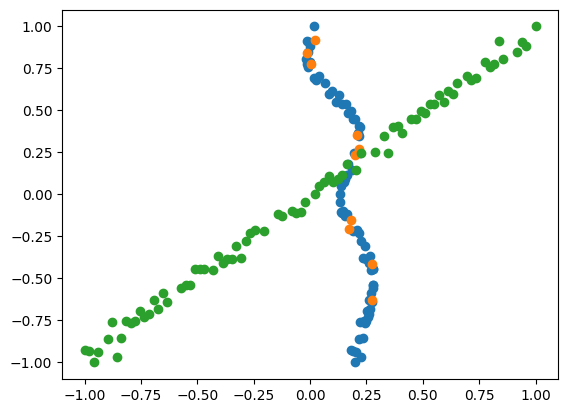

In [31]:
plt.scatter(model.predict(X_train),y_train)
plt.scatter(model.predict(X_test),y_test)
plt.scatter(X_train,y_train)